# On Why Gradient Descent Is Needed

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = [8,8]
plt.style.use('ggplot')
import numpy as np
import pymc3
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  # default='warn'
import datetime
import os

## Back Story
After presenting Deep Learning Without The Hype one of the audience asked me a (few) questions regarding a particular plot/slide and gradient descent. My answers as the time were mostly unsatisfactory, and since I have realised that the plot in question can be misleading one and really should come with some fully explanation. One should spell out exactly why gradient descent is needed/used.
![title](gradient_descent.png)
The question(s) were along the lines of (I hope I remember correctly), and my abridged answers:  
Q: "You don't really have that loss function surface, otherwise why do you need to do gradient descent? Why not just take the minimum?"  
(A: "You don't have that surface.")  
Q: "But then how do do gradient descent?"  
(A: "You have the gradients.")  
Q: "But how do you have the gradients if you don't have the surface?" 

I was nicely caught without an fully clear understanding, so here goes the real answer.

Abridged Answer:
You mathematically and theoretically have the entire Cost/Error/Loss surface (all different names for same thing - just some well defined scalar quantity). And you mathematically and theoretically have the entire vector field of gradients for that surface - i.e. you have all the gradients. But _in reality_ you only have what you are able to compute **with your limited resources and time**. The aim of the game is to find a set of parameters (weights of your model) that make for a low error, and there's no rules on how you do that. But trying to do a grid search (which is akin to plotting/computing the loss surface) in a 1million+ dimension parameter space is going to be slow progress (think years). It is precisely a computation problem that gradient descent overcomes, not a mathematical one. In reality it might be better to think of it as a "search" algorithm rather than an "optimisation" algorithm, i.e. it efficiently searches about in parameter space for areas of low(er) loss.

## Problem Statement - Linear Regression
Example mostly taken from (credit):https://www.coursera.org/learn/machine-learning/supplement/Mc0tF/linear-regression-with-one-variable

### Data

In [3]:
df = pd.DataFrame({'x':[0,1,2,3],'y':[4,7,7,8]})
df

,x,y
0,0,4
1,1,7
2,2,7
3,3,8


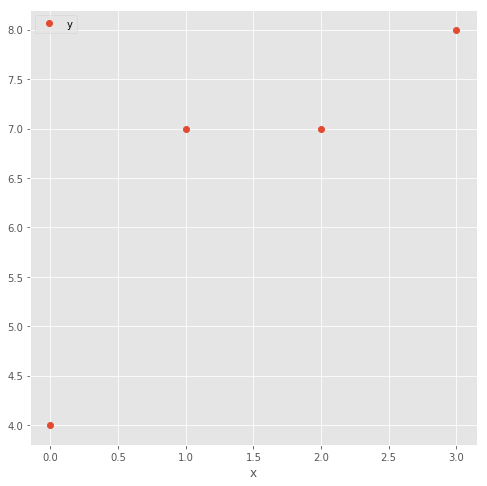

In [4]:
df.plot(x='x',y='y', style='o')

### Model (Hypothesis)
Model has parameters (weights) $w$ & $b$  
$h_{wb}(x) = wx + b$

In [5]:
def h(x,w,b):
    return (w*x) + b

### Cost Function
(Mean-Squared Error)  
$J(w,b)=\frac{1}{2m}\sum\limits_{i=1}^{m} (h_{wb}(x^{(i)})-y^{(i)})^2$

In [6]:
def J(w,b,df=df):
    _df = df.copy()
    _df['h'] = _df.x.map(lambda x: h(x,w,b))
    _df['error_sq'] = (_df.h-_df.y)**2
    return _df.error_sq.sum()/(2*len(_df))

In [7]:
J(0,0)

22.25

In [8]:
J(1,4)

0.75

## Q1: "You don't really have that cost function surface do you?"

## A1: "You have it _mathematically & theoretically only_, but _not computationally_"
$J(w,b)$ is a well defined mathematical quantity, which we can readily compute (as we have in the function `J`). Even
for huge models like Convolutional NNs (Deep Learning stuff), with millions of model parameters (weights) and millions
of training samples (data examples we are optimising for), $J(x_1,...x_{1million})$ is still a function composed of _simple and computable_ mathematical operataions and is thus well defined and computable for a given set of weights.  
The issue arises from the computational requirements to calculate $J(x_1,...x_{1million})$ over the number of different _combinations_ and possible values of weights.  
To explain better let's introduce the idea of a _parameter space_.
#### Parameter Space
This is the space (think like an x-y space/plot) of all possible values that the set of parameters can take.  
Let's visual some of the parameter space for our model $h_{wb}$.

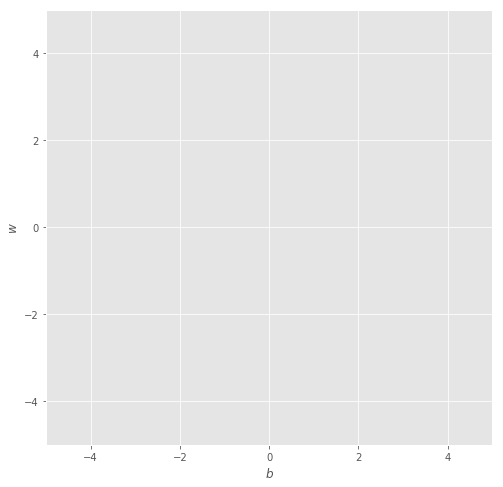

In [9]:
plt.plot([],[])
axes = plt.gca()
axes.set_xlim(-5,5)
axes.set_ylim(-5,5)
plt.ylabel('$w$')
plt.xlabel('$b$')
plt.show()

Very interesting... But seriously, it is important to be clear on this parameter space as this is what the cost function $J(w,b)$ lives (or exists) in.

Ok, now let's plot (i.e. compute/"get") the cost function in our $(w,b)$ parameter space.  
"BUT! didn't you just say we can't get this becasue of computational limitations?"  
Yes, but in our tiny model we don't hit those computational limits. Stick with it for now :)

Because we are in a computer, nothing is continuous (like mathematical functions on paper or in our heads are), so we first need to choose some discretisation, or course-graining, of our parameter space. Let split $w$ & $b$ into 100 points each.

In [10]:
# we don't plot to plot the whole inifite space, so limit it by guessing...
w_max = 10
b_max = 10 

In [11]:
w_s = np.linspace(-w_max,w_max,100)
b_s = np.linspace(-b_max,b_max,100)
print(len(w_s), len(b_s))

100 100


And let's plot them just for good measure aye

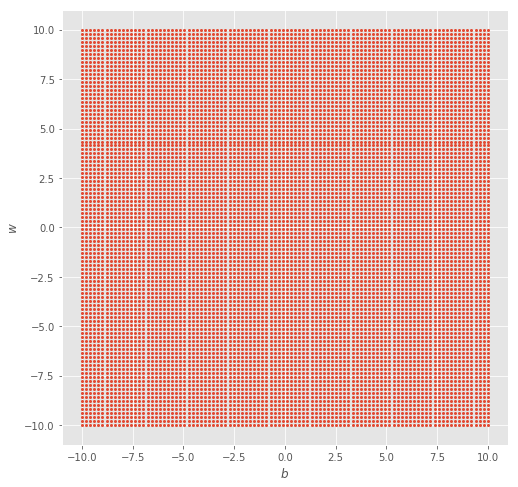

In [12]:
plt.plot([item for sublist in [[w]*len(b_s) for w in w_s] for item in sublist],list(b_s)*len(w_s),'o', markersize=2)
axes = plt.gca()
plt.ylabel('$w$')
plt.xlabel('$b$')
plt.show()

Beautiful. So we've turned out continous parameter space into a discrete set of points.  
Now let's go 3D, and put the cost function (total error from our model) on the new (Z) axis for each point in our ($w$ $b$) parameters space.

In [13]:
W_s, B_s = np.meshgrid(w_s, b_s[::-1])
J_s = J(W_s, B_s)

Text(0.5,0,'$J(w,b)$')

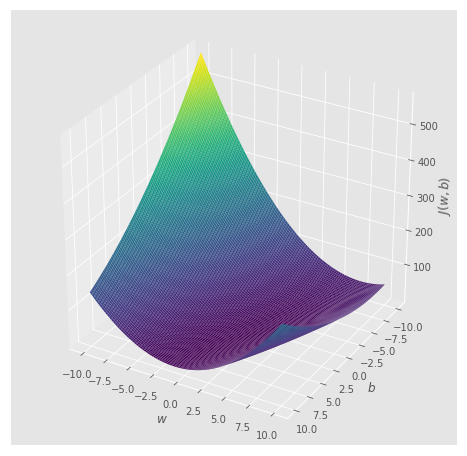

In [14]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(W_s, B_s, J_s, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.invert_yaxis()
ax.set_xlabel('$w$')
ax.set_ylabel('$b$')
ax.set_zlabel('$J(w,b)$')

So we've got the surface, why not skip gradient descent and just read of what parameters are for minimum cost? 

In [15]:
min_ix = np.unravel_index(np.argmin(J_s, axis=None), J_s.shape)

In [16]:
W_s[min_ix]

1.3131313131313131

In [17]:
B_s[min_ix]

4.545454545454545

In [18]:
J(W_s[min_ix],B_s[min_ix])

0.2331139679624528

That's pretty low error, good job us. 

Now let's think about trying to do the same say for a model with 1 million parameters.
1. Our parameter space now has 1 million dimensions (let's not try and "plot" this).
2. We need to decide our course graining. Do we run all parameters from -10 - 10 again? or just -1 to 1. And how many steps/course graninings in those limits should we have? 100, or 1000 or more? How sensitive will out cost function be to parameter changes? If 0.00001 in a parameter for a certain set of (the 1 mill) parameter values make a big change than our course graining might be too fine! Let's choose -1,1 with 100 steps.
3. Ignoring an memory issue we might run into - storing 100 million numbers is getting big. Let's try and get an estimate, or lower bound at least, of computation time to calculate $J(x_1,...x_{1million})$ at 100 steps course grainning. We'll use our 2D parameter space and it's `J`, and then scale up the time it takes.

In [19]:
w_s = np.linspace(-10,10,100)
b_s = np.linspace(-10,10,100)
W_s, B_s = np.meshgrid(w_s, b_s)
J_s = J(W_s, B_s)
min_ix = np.unravel_index(np.argmin(J_s, axis=None), J_s.shape)
print('Cost:',J(W_s[min_ix],B_s[min_ix]))
print('Params:', W_s[min_ix], B_s[min_ix])

Cost: 0.2331139679624528
Params: 1.3131313131313131 4.545454545454545


In [20]:
%%timeit
w_s = np.linspace(-10,10,100)
b_s = np.linspace(-10,10,100)
W_s, B_s = np.meshgrid(w_s, b_s)
J_s = J(W_s, B_s)
min_ix = np.unravel_index(np.argmin(J_s, axis=None), J_s.shape)

1.86 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's increase the parameter space dimension by 1. A standard next model would be to add the square of the $x$ feature.  
$h_2(x) = w_1x + w_2x^2 b$

In [21]:
def h2(x,w_1,w_2,b):
    return (w_1*x) + (w_2*(x**2)) + b

In [22]:
def J2(w_1,w_2,b,df=df):
    _df = df.copy()
    _df['h'] = _df.x.map(lambda x: h2(x,w_1,w_2,b))
    _df['error_sq'] = (_df.h-_df.y)**2
    return _df.error_sq.sum()/(2*len(_df))

In [23]:
w1_s = np.linspace(-10,10,100)
w2_s = np.linspace(-10,10,100)
b_s = np.linspace(-10,10,100)
W1_s, W2_s, B_s = np.meshgrid(w1_s, w2_s, b_s)
J2_s = J2(W1_s, W2_s, B_s)
min_ix = np.unravel_index(np.argmin(J2_s, axis=None), J2_s.shape)
print('Error:', J2(W1_s[min_ix], W2_s[min_ix], B_s[min_ix])) 
print('Params:',W1_s[min_ix], W2_s[min_ix], B_s[min_ix])

Error: 0.10072951739618409
Params: 2.7272727272727266 -0.5050505050505052 4.141414141414142


*Nice!* we beat are previous best cost/error, we halfed it even. A great result, but how much longer did it take?

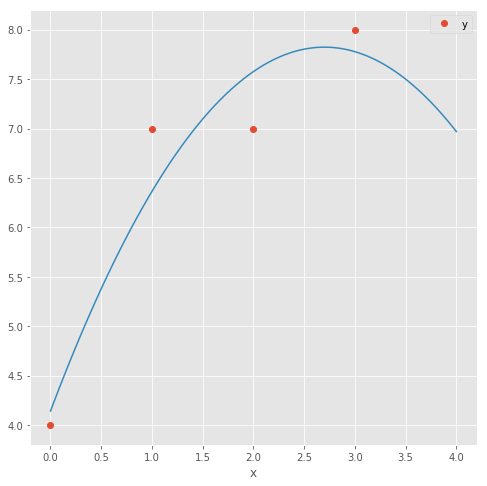

In [24]:
df.plot(x='x',y='y', style='o')
xs = np.linspace(0,4,100)
plt.plot(xs,h2(xs, W1_s[min_ix], W2_s[min_ix], B_s[min_ix]))

In [25]:
%%timeit
w1_s = np.linspace(-10,10,100)
w2_s = np.linspace(-10,10,100)
b_s = np.linspace(-10,10,100)
W1_s, W2_s, B_s = np.meshgrid(w1_s, w2_s, b_s)
J2_s = J2(W1_s, W2_s, B_s)
min_ix = np.unravel_index(np.argmin(J2_s, axis=None), J2_s.shape)

97.2 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


~50 times longer! I hope you can see where this is going (remember we are only on 3 params, and we said we wanted to do 1 million...)

In [26]:
def h3(x,w_1,w_2,w_3,b):
    return (w_1*x) + (w_2*(x**2)) + (w_3*(x**3)) + b

In [27]:
def J3(w_1,w_2,w_3,b,df=df):
    _df = df.copy()
    _df['h'] = _df.x.map(lambda x: h3(x,w_1,w_2,w_3,b))
    _df['error_sq'] = (_df.h-_df.y)**2
    return _df.error_sq.sum()/(2*len(_df))

In [28]:
w1_s = np.linspace(-10,10,100)
w2_s = np.linspace(-10,10,100)
w3_s = np.linspace(-10,10,100)
b_s = np.linspace(-10,10,100)
W1_s, W2_s, W3_s, B_s = np.meshgrid(w1_s, w2_s, w3_s, b_s)
J3_s = J3(W1_s, W2_s, W3_s, B_s)
min_ix = np.unravel_index(np.argmin(J3_s, axis=None), J3_s.shape)
print('Error:', J3(W1_s[min_ix], W2_s[min_ix], W3_s[min_ix], B_s[min_ix])) 
print('Params:',W1_s[min_ix], W2_s[min_ix], W3_s[min_ix], B_s[min_ix])

Error: 0.003035404550555563
Params: 6.161616161616163 -3.737373737373738 0.7070707070707076 3.9393939393939394


Now we beat our previous loss by loads! But this isn't the important bit. Remember we are considering the time is takes to compute and take the minimum of our cost function surface.

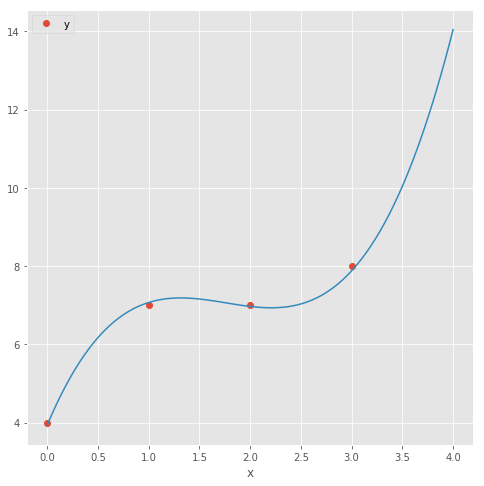

In [29]:
df.plot(x='x',y='y', style='o')
xs = np.linspace(0,4,100)
plt.plot(xs,h3(xs, W1_s[min_ix], W2_s[min_ix], W3_s[min_ix], B_s[min_ix])) #overfitting ;)

In [30]:
%%timeit
w1_s = np.linspace(-10,10,100)
w2_s = np.linspace(-10,10,100)
w3_s = np.linspace(-10,10,100)
b_s = np.linspace(-10,10,100)
W1_s, W2_s, W3_s, B_s = np.meshgrid(w1_s, w2_s, w3_s, b_s)
J3_s = J3(W1_s, W2_s, W3_s, B_s)
min_ix = np.unravel_index(np.argmin(J3_s, axis=None), J3_s.shape)

29.6 s ± 2.55 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


30 whole seconds!?  
Hopefully now you are persuaded of the exponential increase in compute time as we increase the dimensions of our parameter space.  
(Of course we could speed up our compute, by writing more efficient computation sequences, using GPUs, caching intermediate values etc., but the relative increases as we increase dimensions will remain.)

### Grid Search Process (Algorithm)
I hope that it's not becoming apparent that it isn't the Cost Function surface that we actually want (when building useful models), but more precisley we want to _find_ points/areas in our parameter space for which the cost function is low.  
One way of doing that is exactly what we've done above; a _grid search_. We sliced up out space into an n-dimensional grid (n being the number of parameters), then for each point in the grid we computed the cost (error), and then we simply picked point that had the minimum. 
Key conclusions:
* Plotting a surface of a quantity in some space is the same as doing a grid search.
* It (seemingly) works well, and is tractably (i.e. fast enough) computable as low number of dimensions.
* Time to complete search increases $O\^n$ with $n$ being the numebr of parameters in model (parameter space dimension) - this is pretty intuitive as the space you are searching in increases in size like $O\^n$.

Here's another parameter space search process (algorithm)
### Random Search Process (Algorithm)
Process: set some bounds on the parameters in which you want to search within. Randomly choose parameter values (within these bounds), compute the cost function, only keep the parameters values that correspond with the minimum you found.  
Again, the chance to find a "good" set of parameters decreases with the volume of the space increasing, so like $O\^n$.

## Q2: "But then you don't really have the gradients do you?"

## A2a: "You have _all_ the gradients _mathematically & theoretically_, but _computationally_"
## A2b: "You could (maybe) _theoretically_ *solve* for points with stationary gradients (to find mins), but pretty sure you're not going to be able to do so analytically"
Similar situation as to the Cost Function surface. The partial differentials of $J(w,b)$ (or $J(x_1,...x_{1million})$ - just $J$ from now on) are all "well-enough" defined mathematical quantities, which we can readily compute. By differentials we mean precisely $\nabla J$ - a vector field with a dimension for each model parameter (weight). Next we'll explictally calculate and visualise the gradient space of $J$ for our simple model. But to try and persuade you that the same absolutely applies even for huge models like Convolutional NNs (Deep Learning stuff), with millions of model parameters.  
* Remember that all our model are "just" a series of simple linear combinations of numbers follow by some non-linear activation function, chained and chained within the next. Each of these base operations are differentiable "enough" (we'll get to this in a moment), and we know the chain rule so we can differentiate the whole thing no problems! The percieved copmlexity comes from the scale and "depth" of the combinations of these functions.
* On being differentialble enough: 
  * Remember we only care about actually calculating the gradients, not about the validity or mathematical rigure of it's general functional form.
  * Take ReLU for example, it's not strictly fully differentiable at 0, though it left/right differentiable.
  * Remember we are in a computer, and not all the real numbers actually exist, only approximations to them. So you're never going to hit an exact 0, it will probably have been rounded to 0 and then why not just say that the diff at 0 is actually the diff at some other tiny number.
  * Check this for better persuation: https://medium.com/@kanchansarkar/relu-not-a-differentiable-function-why-used-in-gradient-based-optimization-7fef3a4cecec
* This might seem a bit circular - but we can clearly do gradient descent, and it relies on the gradients, so we must be able to compute them aye? ;)
So onto gradient descent properly...

## The aim of the whole game 
The aim of the game is to find a set of parameters (weights of your model) that make for a low error, and there's no rules on how you do that.

### Gradient Descent (Algorithm)
The idea/hueristic: Start at random point in parameter space, calculate the gradient of the cost function at that points - this is the n-dimensional vector of the n partial derivatives of the cost function w.r.t. to each of the n parameters in our model. Move a little in that direction. Repeat.  
Why is it so prevelant? - Because it's so efficient (comparitevly to alternative search/optimisation algorithms). Instead of computing (comparatively) loads of points of the cost function, let's just start at one point and only compute a line of those points that "look" (locally) like they are better (i.e. lower cost) than where we are at. Instead of exploring an entire volume of parameter space as you would in grid search - which scales with power of $n$, instead just explore a single line (which is only 1D!) chosen by following gradients. I think this idea of gradient descent being exploring just along a line and grid search (or other niave methods) exploring an entire volume (in $n$D space so it's painfully big) is a nice way of understanding the kind of efficiency gains that gradient descent provides as we move to dimensions in the millions!  
Hopefully now it feels very much more like a "search" algorithm than an "optimisation" one.

Let's do our little model, time to differentiate:  
$\nabla J(w,b) = \begin{bmatrix}
           \frac{\partial J}{\partial w} \\
           \frac{\partial J}{\partial b} \\
         \end{bmatrix}
= \frac{1}{2m}\begin{bmatrix}
           \frac{\partial}{\partial w} \sum\limits_{i=1}^{m} (h_{wb}(x^{(i)})-y^{(i)})^2 \\
           \frac{\partial}{\partial b} \sum\limits_{i=1}^{m} (h_{wb}(x^{(i)})-y^{(i)})^2 \\
         \end{bmatrix}
= \frac{1}{2m}\begin{bmatrix}
           \frac{\partial}{\partial w} \sum\limits_{i=1}^{m} (wx^{(i)}+b-y^{(i)})^2 \\
           \frac{\partial}{\partial b} \sum\limits_{i=1}^{m} (wx^{(i)}+b-y^{(i)})^2 \\
         \end{bmatrix}
= \frac{1}{m}\begin{bmatrix}
           \sum\limits_{i=1}^{m} (wx^{(i)}+b-y^{(i)})x^{(i)}\\
           \sum\limits_{i=1}^{m} (wx^{(i)}+b-y^{(i)})\\
         \end{bmatrix}
         $  
We could do the same for any model (convultional or otherwise), the only difference being it's going to be a lot more ugly and won't fit into our usual mathematical notations - but remember we don't need to be able to write it down nicely, we just need to be able to compute it.  
Let's plot it just cause we can.

In [31]:
def gradJ(w,b,df=df):
    _df = df.copy()
    _df['h'] = _df.x.map(lambda x: h(x,w,b))
    _df['dw'] = (_df.h-_df.y)*_df.x
    _df['db'] = (_df.h-_df.y)
    # NOTE: because we want to "go down" the cost function, let's multiply the grad by -1 to make positives be "better"
    return np.array([_df.dw.sum(), _df.db.sum()])/(-len(_df))

In [32]:
gradJ(0,0)

array([11.25,  6.5 ])

(2, 25, 25)


Text(0,0.5,'$b$')

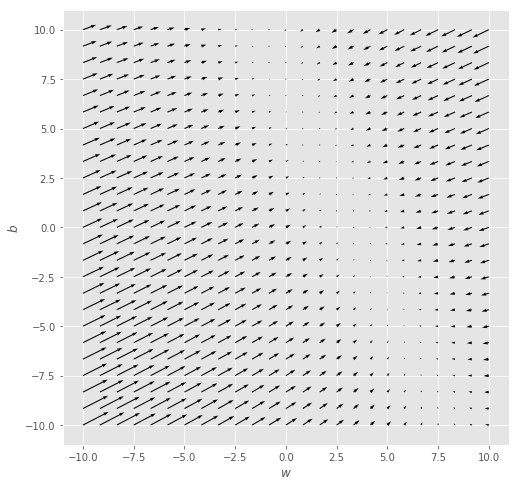

In [33]:
# reduce course graining to make the arrows more visible
w_s = np.linspace(-10,10,25)
b_s = np.linspace(-10,10,25)
W_s, B_s = np.meshgrid(w_s, b_s)
gradJ_s = gradJ(W_s, B_s)
print(gradJ_s.shape)
plt.quiver(W_s, B_s, gradJ_s[0],gradJ_s[1])
ax = plt.gca()
ax.set_xlabel('$w$')
ax.set_ylabel('$b$')
#nice

Similarly as with the Cost Function surface, we can see where the areas where the gradients begin to vanish (i.e. be 0 and are thus a stationary point (hopefully a minimum). We can use this to read off our best parameters.

In [34]:
grad_norms = np.linalg.norm(gradJ_s, axis=0)
grad_norms.shape

(25, 25)

In [35]:
# let's do it at the same course graining to make it fair
w_s = np.linspace(-10,10,100)
b_s = np.linspace(-10,10,100)
W_s, B_s = np.meshgrid(w_s, b_s)
gradJ_s = gradJ(W_s, B_s)
grad_norms = np.linalg.norm(gradJ_s, axis=0)
min_ix = np.unravel_index(np.argmin(grad_norms, axis=None), grad_norms.shape)
print('Size (norm) of gradient:', grad_norms[min_ix])
print('Cost:', J(W_s[min_ix], B_s[min_ix]))
print('Params:', W_s[min_ix], B_s[min_ix])

Size (norm) of gradient: 0.13220848598695314
Cost: 0.23668503213957762
Params: 1.1111111111111107 4.94949494949495


Also similarly as with the Cost Function surface, computing the gradient for a set of points in a volume will completely blow up as that volume become 1million+ dimensional. But computing a few of them is still totally tractable* and exactly what we do in gradient descent. So it's all mathematically avaliable, just don't have the resources + time required to compute for real (big) models.

We could stop here, but just for completeness and to really show there is no funny business going on...  
Let's specify, implement and run actual gradient descent.   
Update/step function:  
$
\begin{bmatrix}
    w \\
    b\\
    \end{bmatrix}
:=
\begin{bmatrix}
    w \\
    b\\
    \end{bmatrix}
- \alpha
\frac{1}{m}\begin{bmatrix}
           \sum\limits_{i=1}^{m} (wx^{(i)}+b-y^{(i)})x^{(i)}\\
           \sum\limits_{i=1}^{m} (wx^{(i)}+b-y^{(i)})\\
         \end{bmatrix}
$

In [36]:
def grad_descent(w_start, b_start, alpha=0.1):
    v = np.array([w_start,b_start])
    v = v + (alpha*gradJ(w_start,b_start)) # use + in the implementation because I added that -1 multiply in gradJ
    return v

In [37]:
steps = []
w_start = 0
b_start = 0
v = np.array([w_start,b_start])
steps.append(v)
for _ in range(1000):
    v = grad_descent(v[0],v[1])
    steps.append(v)

In [38]:
steps[-1]

array([1.2, 4.7])

Size (norm) of gradient: 0.13220848598695314
Cost: 0.22499999999999992
Params: 1.2000000000001225 4.699999999999738


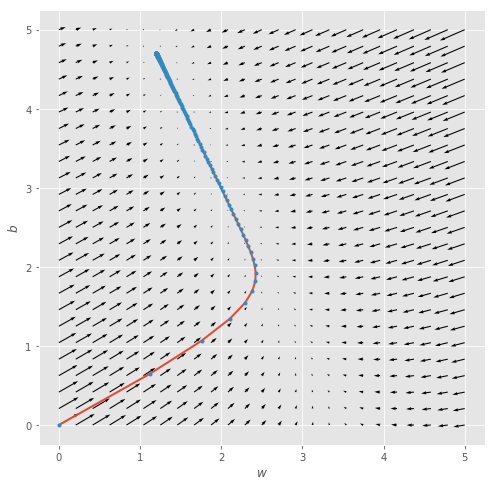

In [39]:
plt.plot([v[0] for v in steps], [v[1] for v in steps], '-',linewidth=2)
plt.plot([v[0] for v in steps], [v[1] for v in steps], 'o', markersize=3, linewidth=1)
w_s = np.linspace(0,5,25)
b_s = np.linspace(0,5,25)
W_s, B_s = np.meshgrid(w_s, b_s)
gradJ_s = gradJ(W_s, B_s)
plt.quiver(W_s, B_s, gradJ_s[0],gradJ_s[1])
ax = plt.gca()
ax.set_xlabel('$w$')
ax.set_ylabel('$b$')
print('Size (norm) of gradient:', grad_norms[min_ix])
print('Cost:', J(steps[-1][0], steps[-1][1]))
print('Params:', steps[-1][0], steps[-1][1])

So that's it, **doing the same for deep learning/CNNs is nothing different, except for an increase in scale**, and the corresponding requirement for increase in systematic code (hence frameworks like TensorFlow and Keras) and increase in computation efficiency (hence using GPUs and using very efficient implementations of grad-descent + other algorithms). 

### Bonus remarks:
• On how to pick learning rate $\alpha$: you try out different factors of 10 until the cost starts going down... (that usually the game anyway). 
• On back-propogation: this is _only_, and nothing more, an efficiency improvement when calculating partial differentials of very nested functions. You should be certain that it's not required for gradient descent (we just did it without back-prop), nor effect the functioning of it (other than speeding up the part of which requires calculating the partial differentials). The one liner explanation of how it works is; nested functions differentiate by chain-rule, apply the (normal "forward") operators $\frac{\partial}{\partial x_i}$ for every $i$ becomes hugely combinatorial and requires multiple re-computing of intermediate partials, but appling the ("backward") operator $\frac{\partial J}{\partial }$ calculates the partials for all parameters "in one pass" without having the combinatorial explosion of computation. Read:http://colah.github.io/posts/2015-08-Backprop/